# Анализ поездок в такси. 

## Часть 2: Fare & Tips.

Тут представлен более подробный анализ признаков Fare и Tips.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df_filename = './data/Taxi_Trips_Clean.zip'

df = pd.read_csv(df_filename)

Сначала вычислим дополнительные признаки.

In [2]:
day_num_to_name = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

df['Average Speed'] = 3600 * df['Trip Miles'] / df['Trip Seconds']
df['Fare Per Mile'] = df['Fare'] / df['Trip Miles']
df['Fare Per Hour'] = 3600 * df['Fare'] / df['Trip Seconds']
df['Tips Per Hour'] = 3600 * df['Tips'] / df['Trip Seconds']
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'].astype(str))
df['Trip End Timestamp'] = pd.to_datetime(df['Trip End Timestamp'].astype(str))

In [3]:
df['Trip Start Day Of Year'] = df['Trip Start Timestamp'].dt.day_of_year
df['Trip End Day Of Year'] = df['Trip End Timestamp'].dt.day_of_year
df['Trip Start Day Of Week'] = df['Trip Start Timestamp'].dt.day_of_week
df['Trip End Day Of Week'] = df['Trip End Timestamp'].dt.day_of_week

df['Trip Start Date'] = pd.to_datetime(df['Trip Start Timestamp'].dt.date.astype('str') + ' 00:00:00')
df['Trip End Date'] = pd.to_datetime(df['Trip End Timestamp'].dt.date.astype('str') + ' 00:00:00')

df['Trip Start Time'] = pd.to_datetime('2000-01-01 '+df['Trip Start Timestamp'].dt.time.astype(str))
df['Trip End Time'] = pd.to_datetime('2000-01-01 '+df['Trip End Timestamp'].dt.time.astype(str))

df['Trip Start Hour'] = df['Trip Start Time'].dt.hour
df['Trip End Hour'] = df['Trip End Time'].dt.hour

Мы уже удостоверились в высокой степени корреляции между Fare и Trip Miles. Рассмотрим временные зависимости признака Fare.
Сразу же построим содержательный график. На нем изобразим прогрессию Fare и Trip Miles в течение суток и добавим линию, отражающую число заказов.

In [4]:
data = df[['Fare', 'Trip Miles', 'Trip Start Hour']].groupby(
    'Trip Start Hour', as_index=False)[['Fare', 'Trip Miles']].agg(Mean_Fare=('Fare','mean'), Mean_Trip_Miles=('Trip Miles', 'mean'), Count=('Fare', 'count')).sort_values('Trip Start Hour').reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


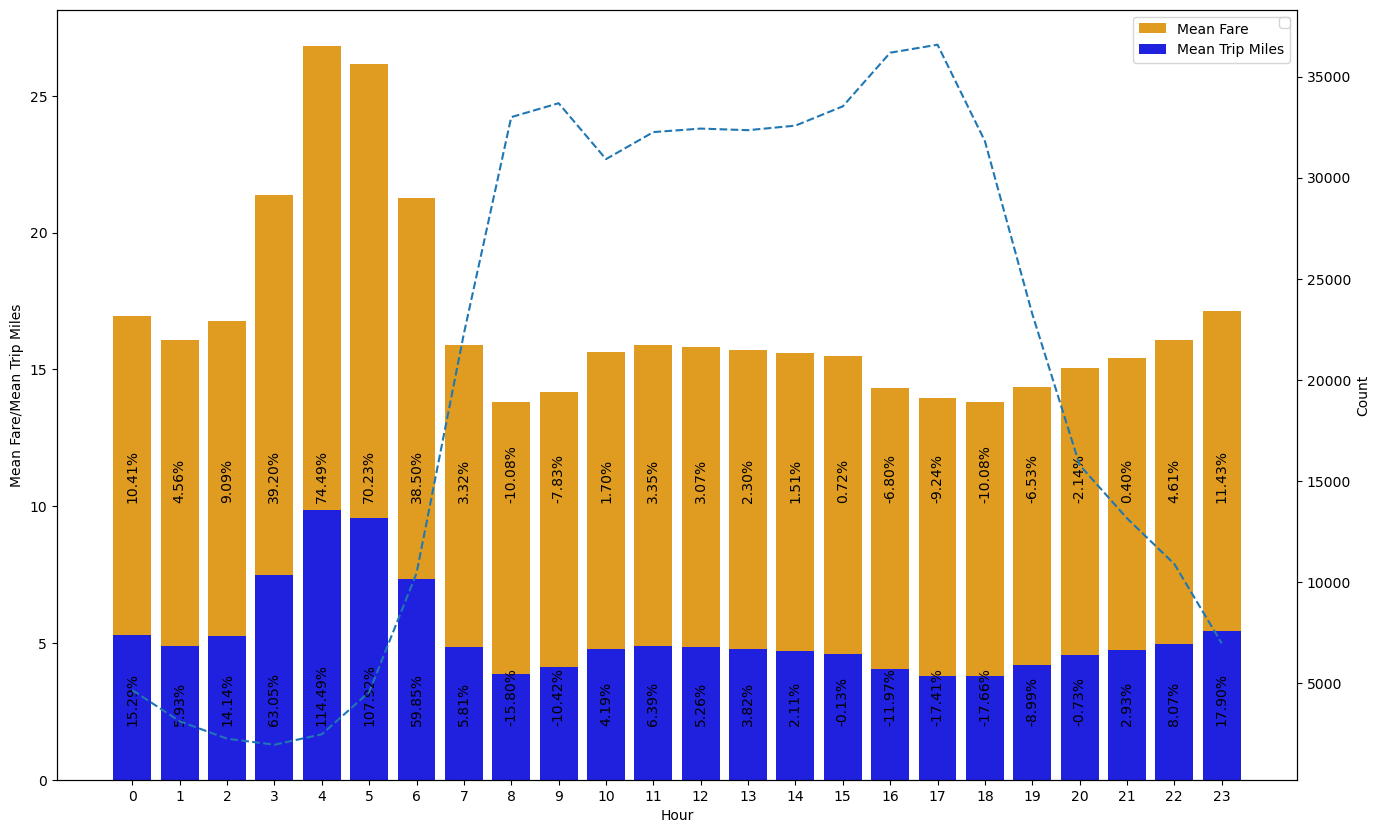

In [5]:
mean_fare, mean_trip_miles = df['Fare'].mean(), df['Trip Miles'].mean()
data['Fare Pct Deviation'] = 100 * (data['Mean_Fare'] - mean_fare) / mean_fare
data['Trip Miles Pct Deviation'] = 100 * \
    (data['Mean_Trip_Miles'] - mean_trip_miles) / mean_trip_miles

fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.set_xlabel('Hour')
ax1.set_ylabel('Mean Fare/Mean Trip Miles')

# Fare
color = 'orange'

barplot_fare = sns.barplot(data,
                           x='Trip Start Hour',
                           y='Mean_Fare',
                           color=color,
                           ax=ax1,
                           label='Mean Fare')

# Trip Miles
color = 'blue'

barplot_trip_miles = sns.barplot(data,
                                 x='Trip Start Hour',
                                 y='Mean_Trip_Miles',
                                 ax=ax1,
                                 color=color,
                                 label='Mean Trip Miles')

ax2 = plt.twinx(ax1)


barplot_count = sns.lineplot(data,
                       x='Trip Start Hour',
                       y='Count',
                       ax=ax2,
                       linestyle='--')
# Подписи

for index, row in data.iterrows():
    barplot_fare.text(x=index, y=mean_fare/1.5,
                 s=f'{row['Fare Pct Deviation']:.2f}%', color='black', ha='center', rotation=90)
    barplot_trip_miles.text(x=index, y=mean_trip_miles/2.2,
                 s=f'{row['Trip Miles Pct Deviation']:.2f}%', color='black', ha='center', rotation=90)

    

plt.legend()
plt.show()

На графике в процентах отмечено отклонение от среднего в процентах.

Можно заметить существенное повышение средней Fare в период с 3 ночи до 7 утра. 
Есть 2 возможные гипотезы, объясняющие это:
- повышение тарифа в ночное время
- увеличение средней продолжительности маршрута, что влечет за собой и увеличение стоимости.

Вторая гипотеза подтверждается сразу же из полученного графика. Проверка первой гипотезы остается задачей с небольшой звездочкой, так как в сущности требуется выделить фактор влияния числа заказов на тариф услуги, выраженной в цене мили. Из графка выше видно, что в часы "пик" средняя продолжительность маршрута понижается, что повышает цену тарифа, однако можно заметить, что 1 и в 12 часов средняя протяженность и средний чек с допущениями одиковы, но спрос отличается примерно на порядок. Если поведение Trip Per Mile будет качественно отличаться в эти два момента времени, то можно сделать некоторые нестрогие выводы о влиянии нагруженности на цену мили.

In [6]:
data = df[['Fare Per Mile', 'Trip Start Hour']].groupby('Trip Start Hour').mean().sort_values('Trip Start Hour').reindex()
mean_fare_per_mile = df['Fare Per Mile'].mean()

data['Fare Per Mile Pct Deviation'] = 100 * (data['Fare Per Mile'] - mean_fare_per_mile) / mean_fare_per_mile

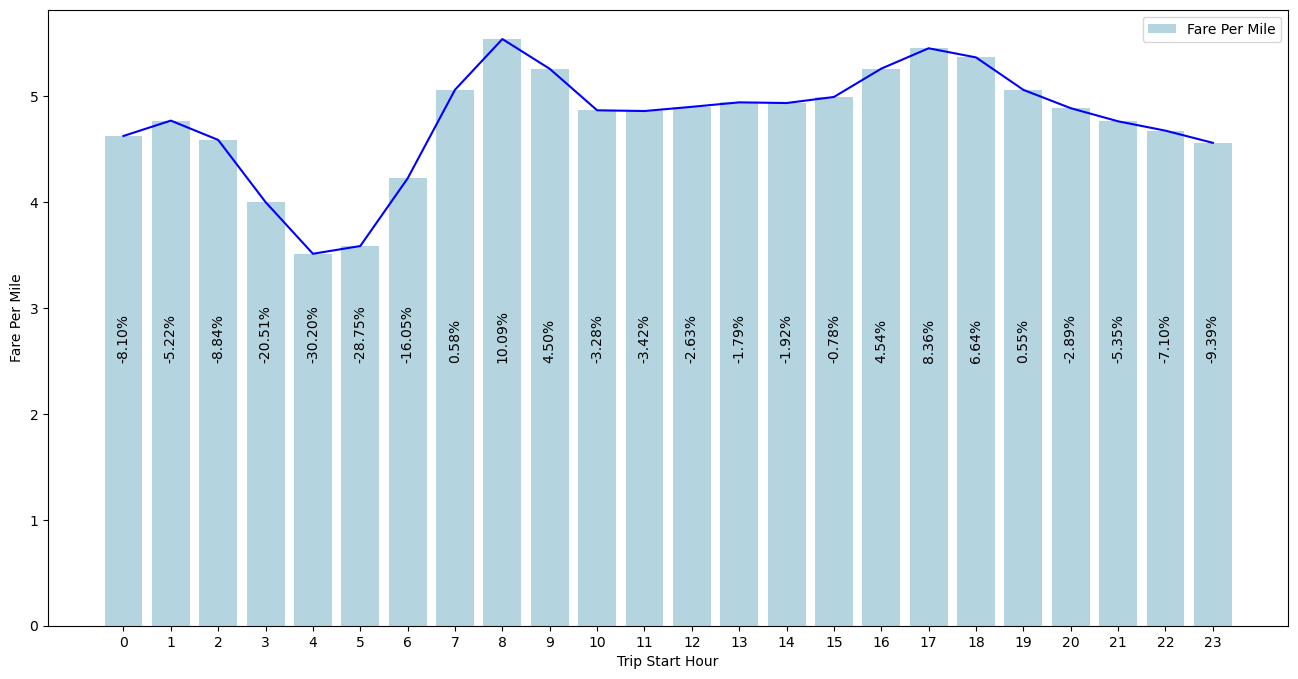

In [7]:
plt.figure(figsize=(16, 8))

barplot = sns.barplot(data,
                      x='Trip Start Hour',
                      y='Fare Per Mile',
                      color='lightblue',
                      label='Fare Per Mile')
sns.lineplot(data,
             x='Trip Start Hour',
             y='Fare Per Mile',
             color='blue')


for index, row in data.iterrows():
    barplot.text(x=index, y=mean_fare_per_mile/2, s=f'{row['Fare Per Mile Pct Deviation']:.2f}%', rotation=90, ha='center')

plt.show()

# data

В итоге из графика получили, что в час ночи средняя стоимость мили на 5.22% ниже средней, в то время как в 12 часов она ниже на 2.63%. Но, обратим внимание на пару временных отметок: 1 и 11 часов.
В час ночи средняя длина маршрута 5.93% выше средней, а в 11 часов -- на 6.39%. Это значит, что в 11 часов цена за милю должна быть ниже, но на полученном графике наблюдается обратное с разницей почти в 2 процента, что косвенно может подтверждать влияние повышенного спроса на ценообразование, однако в ночное время цены за милю как раз снижаются, поэтому существование "ночного тарифа" не подтвердилось и первую гипотезу можно считать ложной.

С другой стороны на зависимость Fare от Trip Miles можно на точечном графике.

In [8]:
data = df[['Fare', 'Trip Miles', 'Trip Start Hour']].sort_values(by='Trip Start Hour')

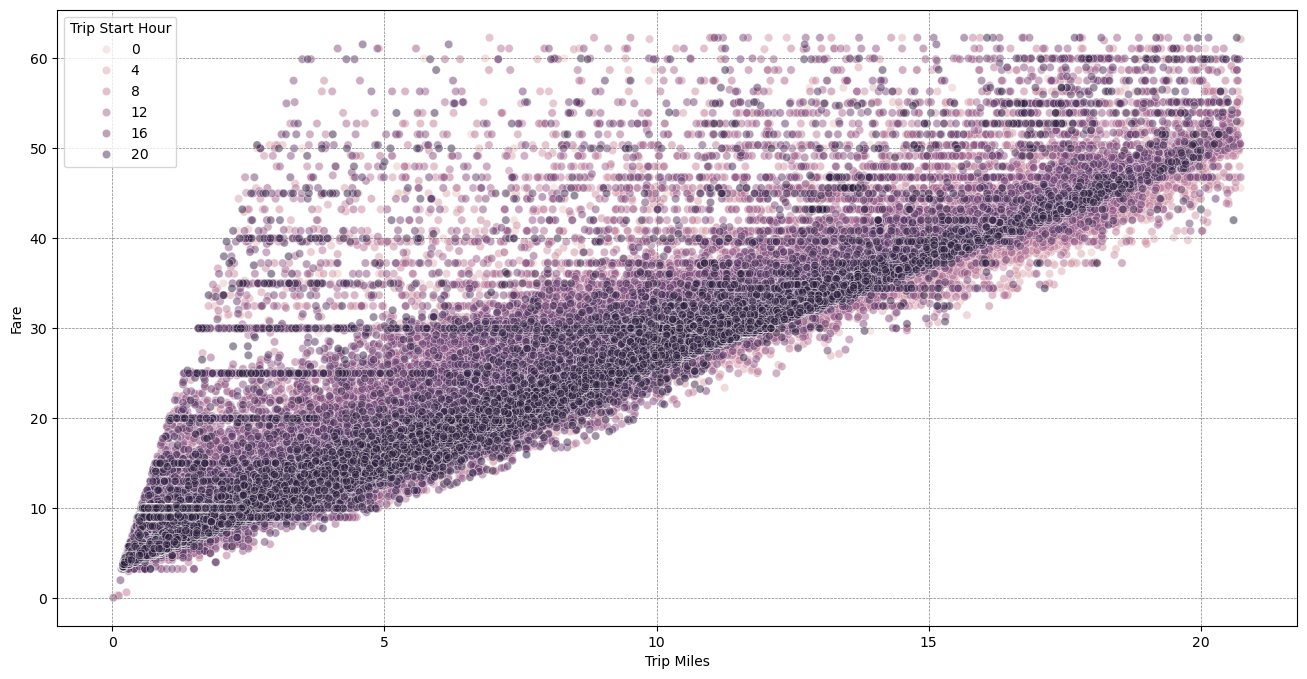

In [9]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data, x='Trip Miles', y='Fare', hue='Trip Start Hour', alpha=0.5)

plt.grid(True, linestyle='--', color='gray', linewidth=0.5)

plt.show()

Хорошо видно, что темные точки (которые соответствуют времени день-вечер) в основном лежат в области меньших знаечний Fare, то есть у них меньше значение Fare Per Mile. В области с повышенными тарифами наоборот, больше всего светлых меток, которые обозначают ночное время суток. Обрывистость границ -- это результат чистки от выбросов.

Похожие графики можно построить и для временного промежутка в виде одной недели.

In [10]:
data = df[['Fare', 'Trip Miles', 'Fare Per Mile', 'Trip Start Day Of Week']].groupby('Trip Start Day Of Week', as_index=False)
data = data[['Fare', 'Fare Per Mile', 'Trip Miles']].agg(Mean_Fare=('Fare','mean'), 
                                                         Mean_Trip_Miles=('Trip Miles', 'mean'), 
                                                         Mean_Fare_Per_Mile=('Fare Per Mile', 'mean'), 
                                                         Count=('Fare', 'count')
                                                         ).sort_values('Trip Start Day Of Week').reset_index()

data['Trip Start Day Name'] = data['Trip Start Day Of Week'].map(day_num_to_name)

In [11]:
data['Fare Pct Deviation'] = 100 * (data['Mean_Fare'] - mean_fare) / mean_fare
data['Trip Miles Pct Deviation'] = 100 * (data['Mean_Trip_Miles'] - mean_trip_miles) / mean_trip_miles
data['Fare Per Mile Pct Deviation'] = 100 * (data['Mean_Fare_Per_Mile'] - mean_fare_per_mile) / mean_fare_per_mile

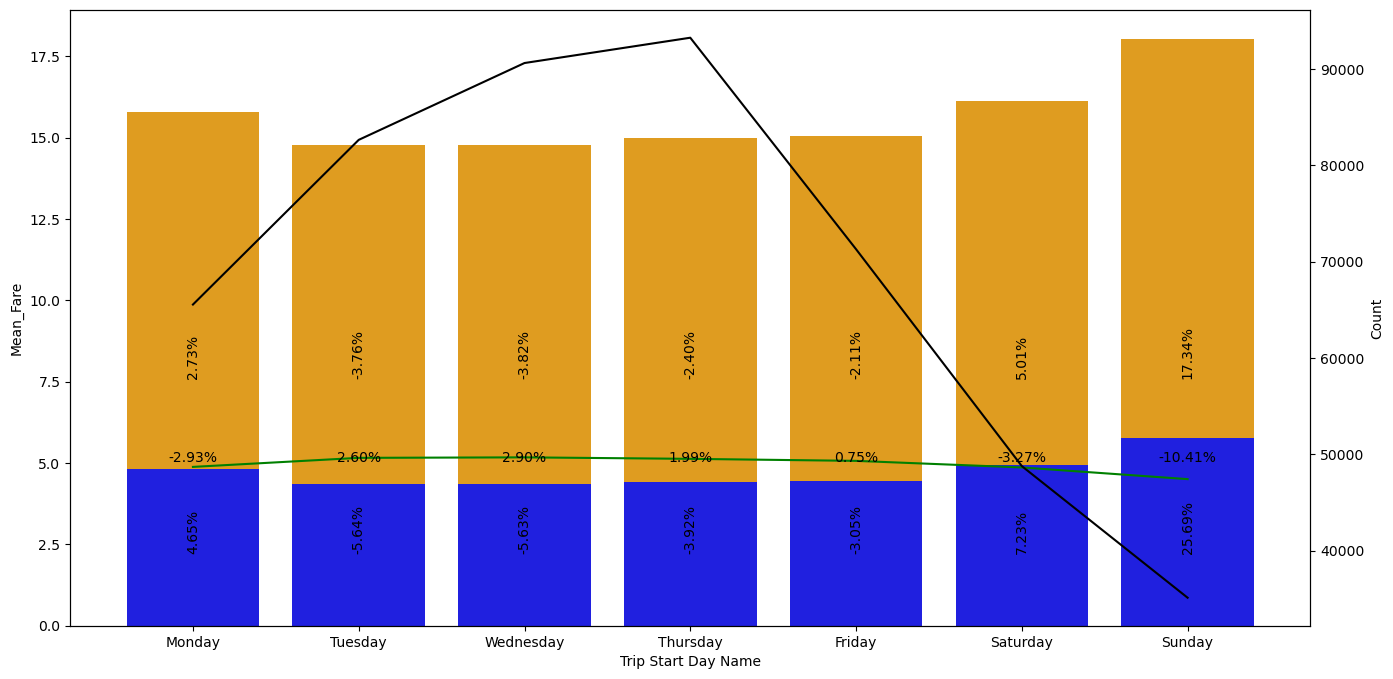

In [12]:
fig, ax1 = plt.subplots(figsize=(16, 8))


# Fare
barplot_fare = sns.barplot(data,
                           x='Trip Start Day Name', y='Mean_Fare',
                           ax=ax1, color='orange')

# Trip Miles
barplot_trip_miles = sns.barplot(data,
                                 x='Trip Start Day Name', y='Mean_Trip_Miles',
                                 ax=ax1, color='blue')

# Trip Per Mile
lineplot_fare_per_mile = sns.lineplot(data,
                                    x='Trip Start Day Name', y='Mean_Fare_Per_Mile',
                                    ax=ax1, color='green')

for index, row in data.iterrows():
    barplot_fare.text(x=index, y=mean_fare/2,
                      s=f'{row['Fare Pct Deviation']:.2f}%',
                      rotation=90, ha='center')
    barplot_trip_miles.text(x=index, y=mean_trip_miles/2,
                            s=f'{row['Trip Miles Pct Deviation']:.2f}%',
                            rotation=90, ha='center')
    lineplot_fare_per_mile.text(x=index, y=mean_fare_per_mile,
                                s=f'{row['Fare Per Mile Pct Deviation']:.2f}%',
                                ha='center')

# Count
ax2 = plt.twinx()
sns.lineplot(data,
             x='Trip Start Day Name', y='Count',
             ax=ax2, color='black')
plt.show()

В данном случае никаких особых явлений не наблюдается. Максимум числа поездок приходится на среду-четверг. В эти дни сокращается протяженность маршрутов и стоимость поездок и увеличивается стоимость одной мили пути. В воскресенье существенно падает число заказов и увеличивается доля длительных поездок.

Относительно всего временного промежутка наблюдений будем проверять наличие трендов: насколько в целом меняется число заказов, их средняя стоимость, длина маршрута и стоимость одной мили.

In [13]:
data = df[['Fare', 'Trip Miles', 'Fare Per Mile', 'Trip Start Date']].groupby(by='Trip Start Date')
data = data[['Fare', 'Trip Miles', 'Fare Per Mile']].agg(Mean_Fare=('Fare','mean'), 
                                                         Mean_Trip_Miles=('Trip Miles', 'mean'), 
                                                         Mean_Fare_Per_Mile=('Fare Per Mile', 'mean'), 
                                                         Count=('Fare', 'count')
                                                         ).sort_values('Trip Start Date').reset_index()

In [14]:
data['Fare Pct Deviation'] = 100 * (data['Mean_Fare'] - mean_fare) / mean_fare
data['Trip Miles Pct Deviation'] = 100 * (data['Mean_Trip_Miles'] - mean_trip_miles) / mean_trip_miles
data['Fare Per Mile Pct Deviation'] = 100 * (data['Mean_Fare_Per_Mile'] - mean_fare_per_mile) / mean_fare_per_mile

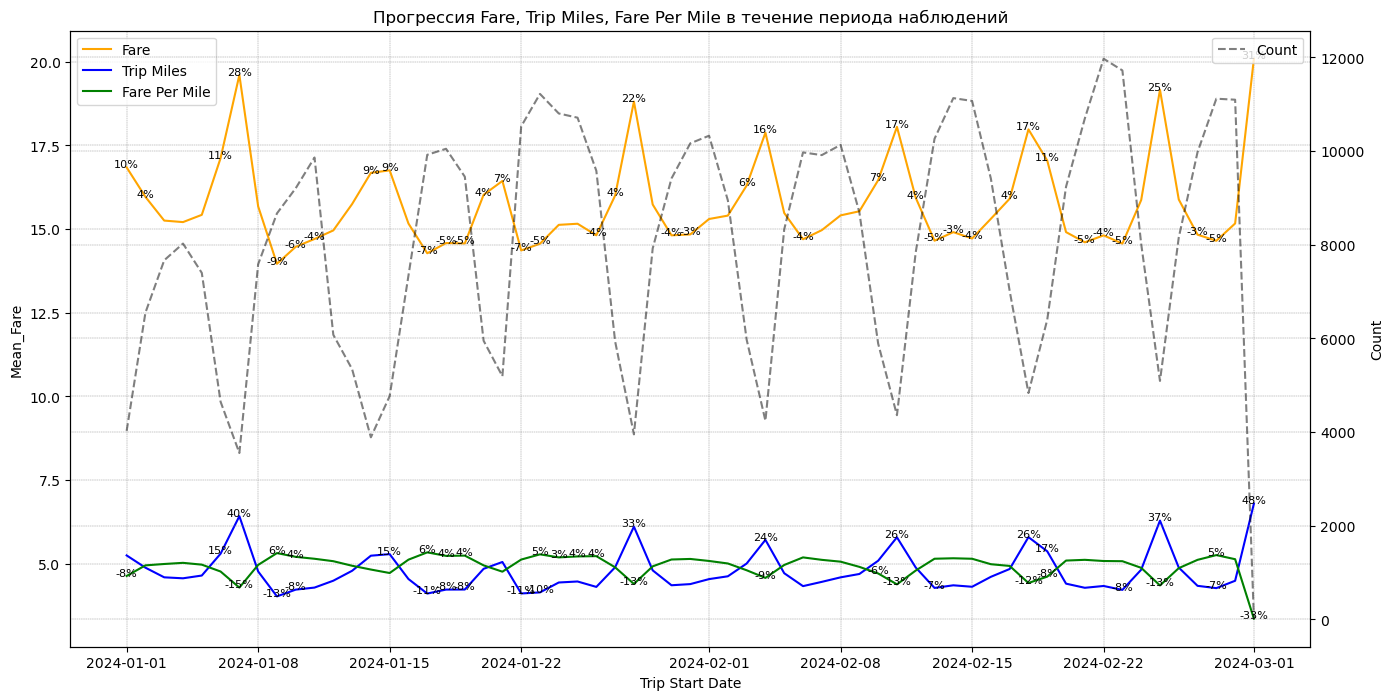

In [15]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Fare
lineplot_fare = sns.lineplot(data,
                             x='Trip Start Date', y='Mean_Fare',
                             ax=ax1, color='orange',
                             label='Fare')

# Trip Miles
lineplot_trip_miles = sns.lineplot(data,
                                   x='Trip Start Date', y='Mean_Trip_Miles',
                                   ax=ax1, color='blue',
                                   label='Trip Miles')

# Fare Per Mile
lineplot_fare_per_mile = sns.lineplot(data,
                                      x='Trip Start Date', y='Mean_Fare_Per_Mile',
                                      ax=ax1, color='green',
                                      label='Fare Per Mile')

for index, row in pd.concat([data.sort_values('Mean_Fare', ascending=False).iloc[:20],
                             data.sort_values('Mean_Fare', ascending=False).iloc[-20:]]
                            ).iterrows():
    lineplot_fare.text(x=row['Trip Start Date'], y=row['Mean_Fare'],
                       s=f'{row['Fare Pct Deviation']:.0f}%', 
                       ha='center', fontsize=8)

for index, row in pd.concat([data.sort_values('Mean_Trip_Miles', ascending=False).iloc[:10],
                             data.sort_values('Mean_Trip_Miles', ascending=False).iloc[-10:]]
                            ).iterrows():
    lineplot_trip_miles.text(x=row['Trip Start Date'], y=row['Mean_Trip_Miles'], 
                             s=f'{row['Trip Miles Pct Deviation']:.0f}%', 
                             ha='center', fontsize=8)
for index, row in pd.concat([data.sort_values('Mean_Fare_Per_Mile', ascending=False).iloc[:10],
                             data.sort_values('Mean_Fare_Per_Mile', ascending=False).iloc[-10:]]
                            ).iterrows():
    lineplot_fare_per_mile.text(x=row['Trip Start Date'], y=row['Mean_Fare_Per_Mile'], 
                                s=f'{row['Fare Per Mile Pct Deviation']:.0f}%', 
                                ha='center', fontsize=8)

ax2 = plt.twinx()
sns.lineplot(data,
             x='Trip Start Date', y='Count',
             ax=ax2,
             color='black', linestyle='--', alpha=0.5,
             label='Count')

ax1.grid(True, linestyle='--', color='gray', linewidth=0.3)
ax2.grid(True, linestyle='--', color='gray', linewidth=0.3)

plt.title('Прогрессия Fare, Trip Miles, Fare Per Mile в течение периода наблюдений')

plt.show()

Наблюдаются найденные ранее недельные осцилляции. Выраженный тренд на повышение имеет только число заказов, но трудно сказать, явялется ли это общей тенденцией или ремиссией после новогодних и рождественских праздников.

Проанализируем также и изменения чаевых и пошлин (Tips, Tolls) в течение дня и недели.

In [16]:
data = df[['Tips', 'Tolls', 'Trip Start Hour']].groupby('Trip Start Hour')
data = data[['Tips', 'Tolls']].agg(Mean_Tips=('Tips', 'mean'), Mean_Tolls=('Tolls', 'mean'))


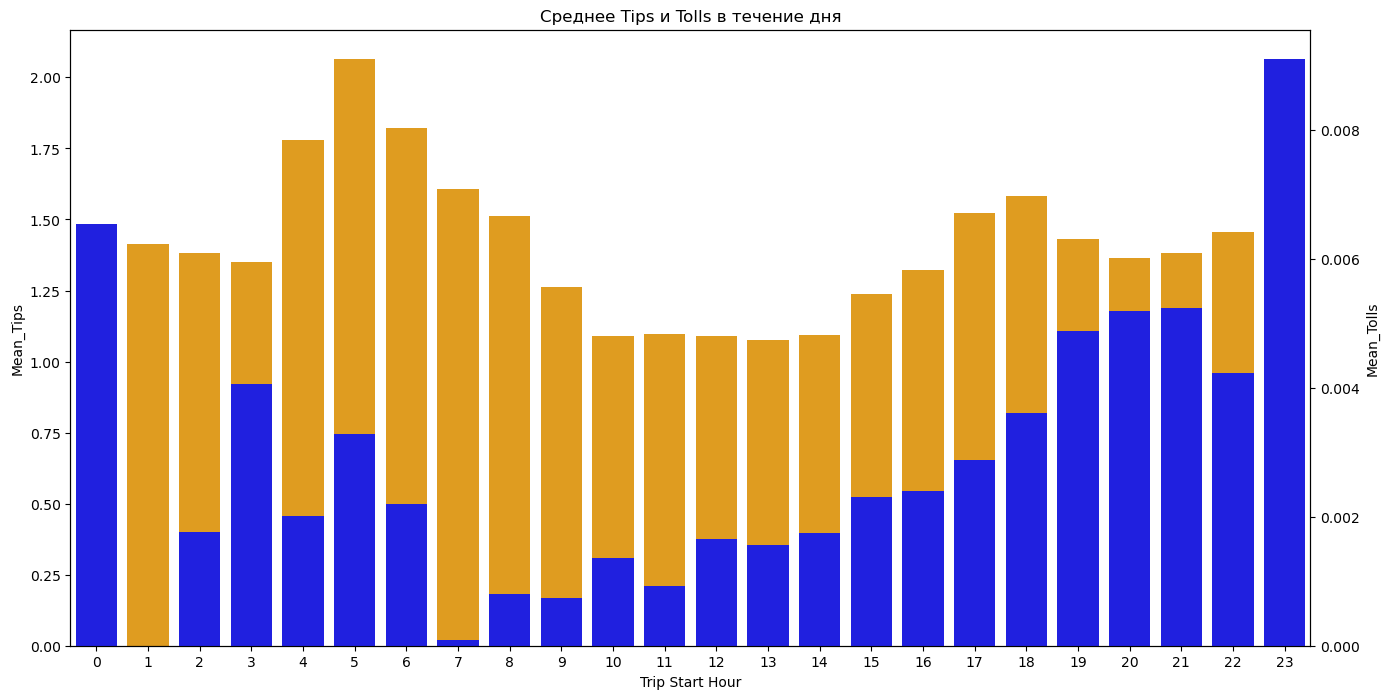

In [17]:
fig, ax1 = plt.subplots(figsize=(16, 8))


sns.barplot(data,
            x='Trip Start Hour', y='Mean_Tips',
            ax=ax1, color='orange', label='Mean Tips')

ax2 = plt.twinx()
sns.barplot(data,
            x='Trip Start Hour', y='Mean_Tolls',
            ax=ax2, color='blue', label='Mean Tolls')

plt.title('Среднее Tips и Tolls в течение дня')

plt.show()

Среднее значение Tolls колеблется ниже значений $0.01, поэтому далее уберем этот признак из рассмотрения. Чаевые представляют интерес, так как их поведение похоже на поведение средней продолжительности пути. Проверим это и следующую гипотезу -- есть догадки, что чаеые тем выше, чем быстрее водитель добирается до места назначения, то есть должна быть связь со средней скоростью перемещения.

Дополнительно надо рассмотреть удельные чаевые, то есть размер чаевых, которые водитель получает за определенный отрезок времени (возьмем час). Проверим все это на совместном графике.

In [18]:
data = df[['Tips', 'Trip Miles', 'Average Speed', 'Trip Start Hour', 'Tips Per Hour']]
data = data.groupby('Trip Start Hour', as_index=False)

data = data[['Tips', 'Trip Miles', 'Average Speed', 'Tips Per Hour']].agg(
    Mean_Tips=('Tips', 'mean'),
    Mean_Trip_Miles=(
        'Trip Miles', 'mean'),
    Mean_Average_Speed=(
        'Average Speed', 'mean'),
    Mean_Tips_Per_Hour=(
        'Tips Per Hour', 'mean')
).sort_values('Trip Start Hour').reindex()

In [19]:
mean_tips = df['Tips'].mean()
mean_average_speed = df['Average Speed'].mean()
mean_tips_per_hour = (3600 * df['Tips'] / df['Trip Seconds']).mean()

data['Tips Pct Diff'] = 100 * (data['Mean_Tips'] - mean_tips) / mean_tips
data['Trip Miles Pct Diff'] = 100 * (data['Mean_Trip_Miles'] - mean_trip_miles) / mean_trip_miles
data['Average Speed Pct Diff'] = 100 * (data['Mean_Average_Speed'] - mean_average_speed) / mean_average_speed
data['Tips Per Hour Pct Diff'] = 100 * (data['Mean_Tips_Per_Hour'] - mean_tips_per_hour) / mean_tips_per_hour

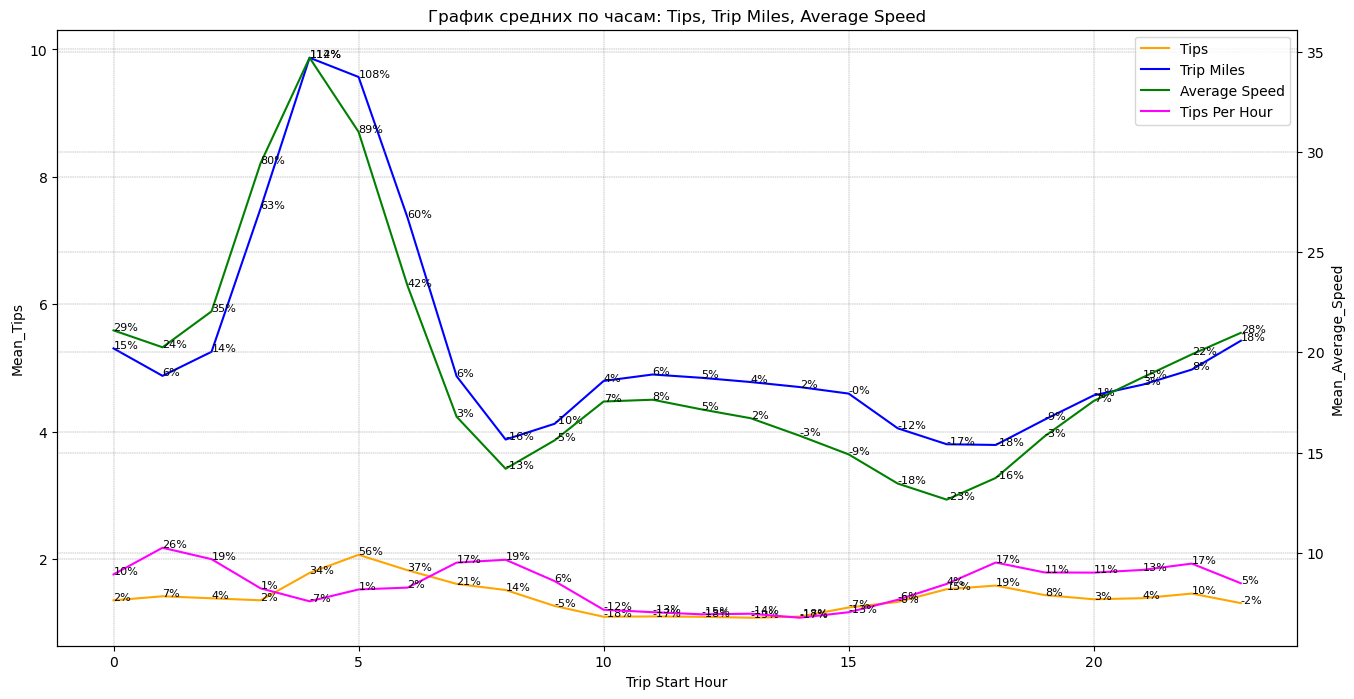

In [20]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Tips
lineplot_tips = sns.lineplot(data,
                             x='Trip Start Hour', y='Mean_Tips',
                             ax=ax1, color='orange', label='Tips')

# Trip Miles
lineplot_trip_miles = sns.lineplot(data,
                                   x='Trip Start Hour', y='Mean_Trip_Miles',
                                   ax=ax1, color='blue', label='Trip Miles')


ax2 = plt.twinx()

# Average Speed
lineplot_average_speed = sns.lineplot(data,
                                      x='Trip Start Hour', y='Mean_Average_Speed',
                                      ax=ax2, color='green', label='Average Speed')

# Tips Per Hour
lineplot_tips_per_hour = sns.lineplot(data,
                                      x='Trip Start Hour', y='Mean_Tips_Per_Hour',
                                      ax=ax2, color='magenta', label='Tips Per Hour')
for index, row in data.iterrows():
    lineplot_tips.text(x=row['Trip Start Hour'], y=row['Mean_Tips'],
                       s=f'{row['Tips Pct Diff']:.0f}%', fontsize=8)
    lineplot_trip_miles.text(x=row['Trip Start Hour'], y=row['Mean_Trip_Miles'],
                             s=f'{row['Trip Miles Pct Diff']:.0f}%', fontsize=8)
    lineplot_average_speed.text(x=row['Trip Start Hour'], y=row['Mean_Average_Speed'],
                                s=f'{row['Average Speed Pct Diff']:.0f}%', fontsize=8)
    lineplot_tips_per_hour.text(x=row['Trip Start Hour'], y=row['Mean_Tips_Per_Hour'],
                                s=f'{row['Tips Per Hour Pct Diff']:.0f}%', fontsize=8)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.get_legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax1.grid(True, linestyle='--', color='gray', linewidth=0.3)
ax2.grid(True, linestyle='--', color='gray', linewidth=0.3)

plt.title('График средних по часам: Tips, Trip Miles, Average Speed')
plt.show()

Четко выраженной зависимости Tips и Trip Miles/Average Speed не наблюдается. Более точно это можно проверить через коэффициент корреляции. Заметим, что чаевые в ночное время больше. Тут можно рассуждать о причинах -- нам нравится мысль о том, что пассажиры в ночное время испытывают большее чувство благодарности к водителю, что побуждает давать больше чаевых, но математически проверить это мы не в силах.

Проверим корреляции:

<Axes: >

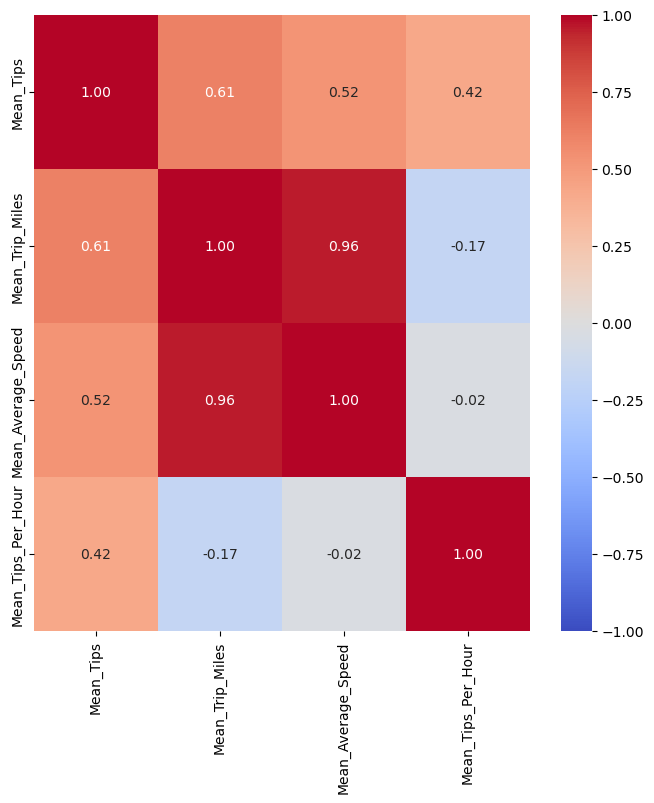

In [21]:
plt.figure(figsize=(8,8))

sns.heatmap(data[['Mean_Tips', 'Mean_Trip_Miles', 'Mean_Average_Speed', 'Mean_Tips_Per_Hour']].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')

Оказалось, что корреляция между продолжительностью маршрута и чаевыми больше, чем между средней скоростью и размером чаевых. Практически с точки зрения водителя в этой информации смысла мало, так как надо рассматривать размер чаевых в пересчете затраченное время.

Если же рассматривать скорость заработка на чаевых, то становится понятно, что их размер практически не зависит от средней скорости движения и обратен дистанции, поэтому тут можно составить хорошую стратегию по максимизации заработка на чаевых на день для водителя -- лучше работать утром или вечером, когда много коротких маршрутов и не работать в ночное и дневное время. Несмотря на то, что размер чаевых выше ночью, времени на получение уйдет больше.

Далее посмотрим на характер чаевых в течение недели.

In [22]:
data = df[['Tips', 'Tips Per Hour', 'Trip Miles', 'Average Speed', 'Trip Start Day Of Week']]
data = data.groupby('Trip Start Day Of Week', as_index=False)

data = data[['Tips', 'Trip Miles', 'Average Speed', 'Tips Per Hour']].agg(
    Mean_Tips=('Tips', 'mean'),
    Mean_Trip_Miles=(
        'Trip Miles', 'mean'),
    Mean_Average_Speed=(
        'Average Speed', 'mean'),
    Mean_Tips_Per_Hour=(
        'Tips Per Hour', 'mean')
).sort_values('Trip Start Day Of Week').reindex()

data['Trip Start Day Name'] = data['Trip Start Day Of Week'].map(day_num_to_name)

In [23]:
data['Tips Pct Diff'] = 100 * (data['Mean_Tips'] - mean_tips) / mean_tips
data['Trip Miles Pct Diff'] = 100 * (data['Mean_Trip_Miles'] - mean_trip_miles) / mean_trip_miles
data['Average Speed Pct Diff'] = 100 * (data['Mean_Average_Speed'] - mean_average_speed) / mean_average_speed
data['Tips Per Hour Pct Diff'] = 100 * (data['Mean_Tips_Per_Hour'] - mean_tips_per_hour) / mean_tips_per_hour

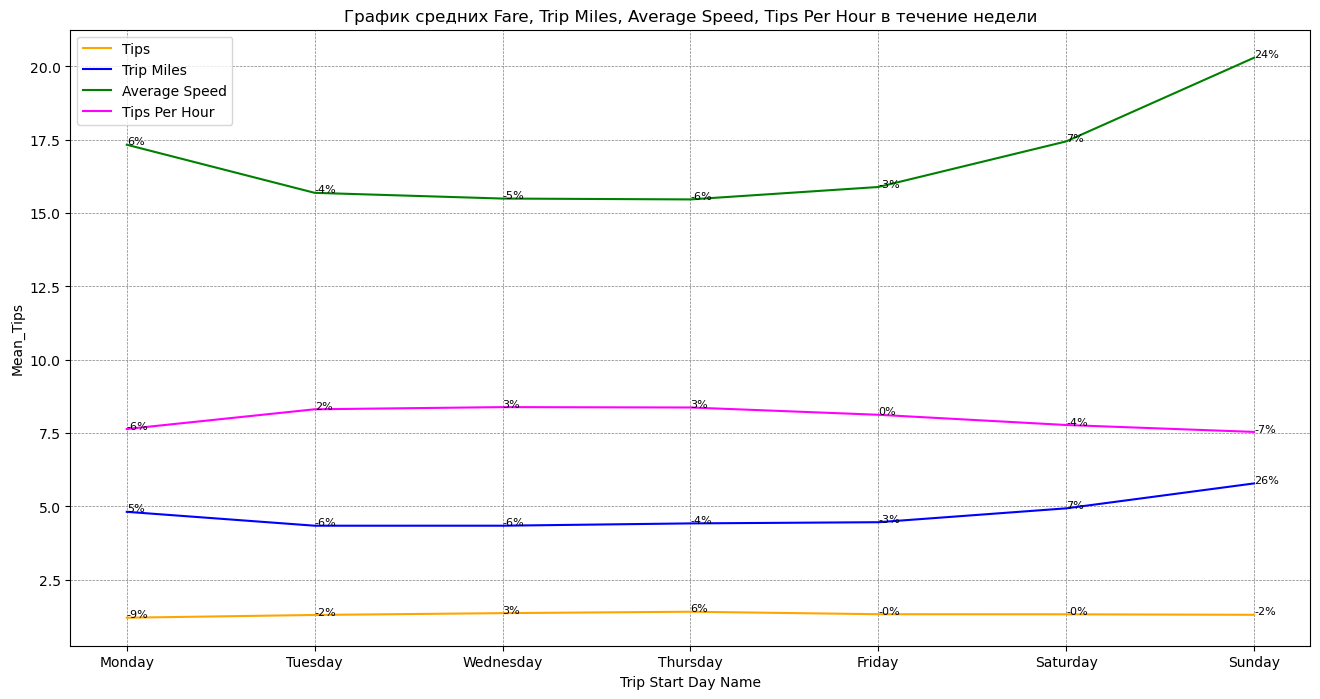

In [24]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Tips
lineplot_tips = sns.lineplot(data,
                             x='Trip Start Day Name', y='Mean_Tips',
                             ax=ax1, color='orange', label='Tips')

# Trip Miles
lineplot_trip_miles = sns.lineplot(data,
                                   x='Trip Start Day Name', y='Mean_Trip_Miles',
                                   ax=ax1, color='blue', label='Trip Miles')

# Average Speed
lineplot_average_speed = sns.lineplot(data,
                                      x='Trip Start Day Name', y='Mean_Average_Speed',
                                      ax=ax1, color='green', label='Average Speed')

# Tips Per Hour
lineplot_tips_per_hour = sns.lineplot(data,
                                      x='Trip Start Day Name', y='Mean_Tips_Per_Hour',
                                      ax=ax1, color='magenta', label='Tips Per Hour')

for index, row in data.iterrows():
    lineplot_tips.text(x=row['Trip Start Day Name'], y=row['Mean_Tips'],
                       s=f'{row['Tips Pct Diff']:.0f}%', fontsize=8)
    lineplot_trip_miles.text(x=row['Trip Start Day Name'], y=row['Mean_Trip_Miles'],
                             s=f'{row['Trip Miles Pct Diff']:.0f}%', fontsize=8)
    lineplot_average_speed.text(x=row['Trip Start Day Name'], y=row['Mean_Average_Speed'],
                                s=f'{row['Average Speed Pct Diff']:.0f}%', fontsize=8)
    lineplot_tips_per_hour.text(x=row['Trip Start Day Name'], y=row['Mean_Tips_Per_Hour'],
                                s=f'{row['Tips Per Hour Pct Diff']:.0f}%', fontsize=8)

plt.title('График средних Fare, Trip Miles, Average Speed, Tips Per Hour в течение недели')
plt.grid(True, linestyle='--', color='gray', linewidth=0.5)

plt.show()

На всех графиках в процентах выражено отношение показателя к среднему значению по всему датасету.

В течение недели практически нет никаких значительных изменений в повежении скорости заработка чаевых, но характеры полученных кривых схожи. Добавим проверку через корреляции.

<Axes: >

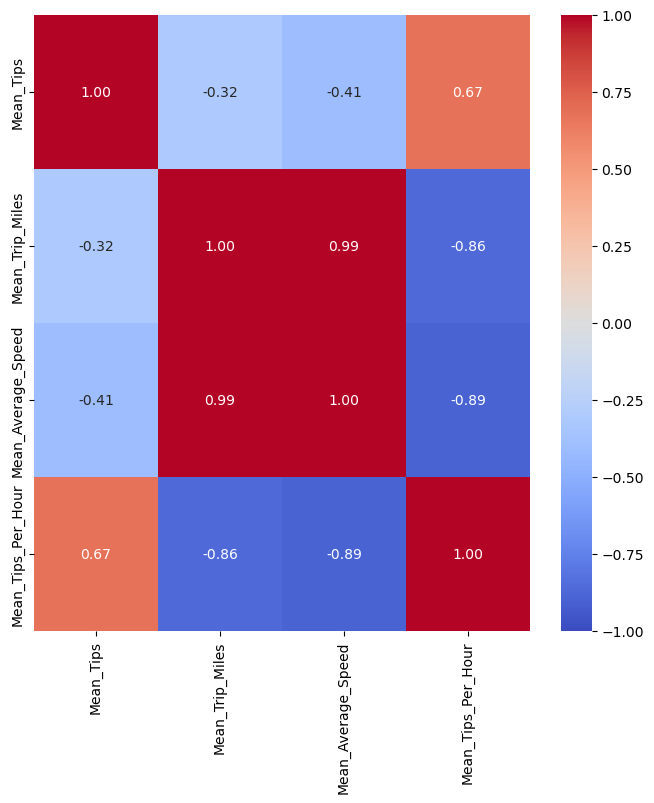

In [25]:
plt.subplots(figsize=(8, 8))

sns.heatmap(data[['Mean_Tips', 'Mean_Trip_Miles', 'Mean_Average_Speed', 'Mean_Tips_Per_Hour']].corr(),
            annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')

На этой таблице результаты еще более явные -- чем быстрее водитель движется, тем меньше чаевых в час получает. Но тут на самом деле зависимость, скорее всего не прямая, а транзитная через длительность маршрута.

Далее посмотрим на то, как влияют категориальные признаки Payment Type и Company на средние чаевые за заказ и за час работы.

In [26]:
data = df[['Tips', 'Tips Per Hour', 'Payment Type']].groupby('Payment Type', as_index=False)
data = data.agg(Mean_Tips=('Tips', 'mean'), Mean_Tips_Per_Hour=('Tips Per Hour', 'mean')).sort_values('Mean_Tips', ascending=False).reset_index()

In [27]:
data

,index,Payment Type,Mean_Tips,Mean_Tips_Per_Hour
0,1,Credit Card,2.949456,19.767252
1,3,Mobile,2.700094,14.547207
2,5,Prcard,0.149047,0.562625
3,6,Unknown,0.004265,0.015670
4,0,Cash,0.001275,0.008746
5,2,Dispute,0.000000,0.000000
6,4,No Charge,0.000000,0.000000


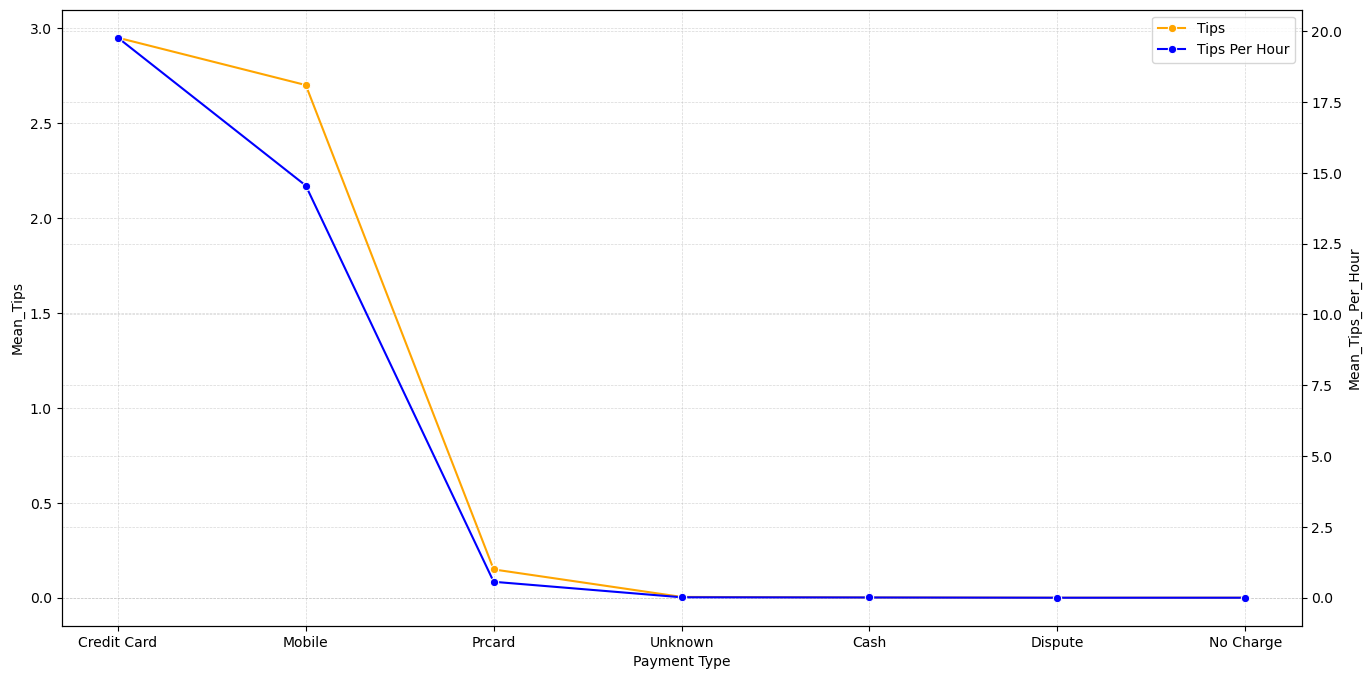

In [28]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Tips
sns.lineplot(data,
             x='Payment Type', y='Mean_Tips',
             ax=ax1, marker='o', color='orange',
             label='Tips')

# Tips Per Hour
ax2 = plt.twinx()
sns.lineplot(data,
             x='Payment Type', y='Mean_Tips_Per_Hour',
             ax=ax2, marker='o', color='blue',
             label='Tips Per Hour')

# Grid
ax1.grid(linestyle='--', linewidth=0.5, alpha=0.5)
ax2.grid(linestyle='--', linewidth=0.5, alpha=0.5)

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.get_legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

Заметим, что средние чаевые за заказ и за час гораздо выше при безналичном расчете, что скорее всего обусловлено удобством оперированием через приложения и терминалы, где можно выставить произвольную сумму чаевых (включая выражение в процентах от Fare) и автоматическую оплату чаевых водителю.

In [29]:
data = df[['Tips', 'Tips Per Hour', 'Company']].groupby('Company', as_index=False)
data = data.agg(Mean_Tips=('Tips', 'mean'), Mean_Tips_Per_Hour=('Tips Per Hour', 'mean')).reset_index()
data = data.join(100 * df['Company'].value_counts(normalize=True), on='Company').rename(mapper={'proportion': 'Company Share'}, axis='columns')
data = data.sort_values('Company Share', ascending=False).reset_index()

/tmp/ipykernel_153875/3660198389.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


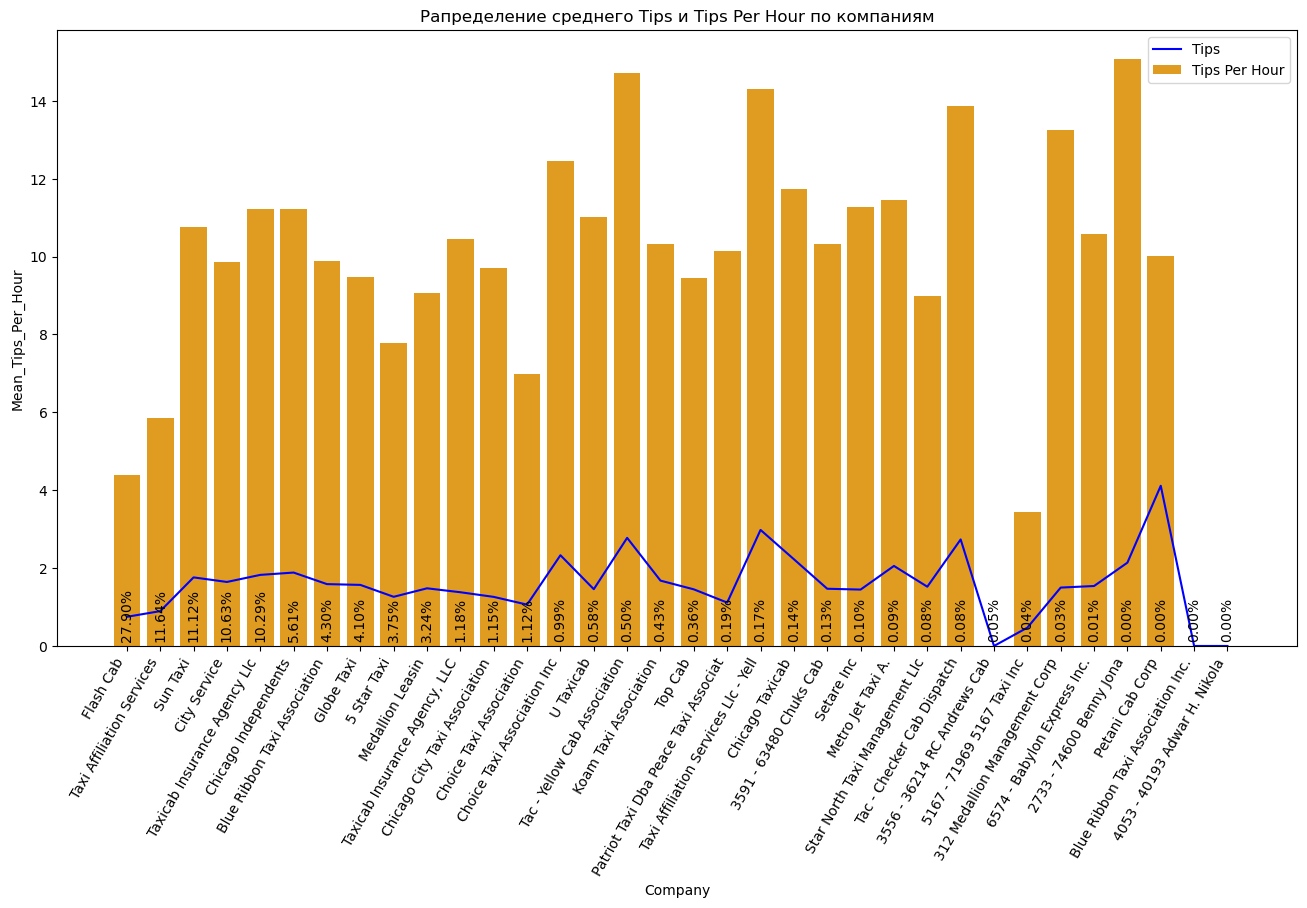

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.barplot(data,
            x='Company', y='Mean_Tips_Per_Hour',
            color='orange', label='Tips Per Hour')

lineplot_tips = sns.lineplot(data,
            x='Company', y='Mean_Tips',
            color='blue', label='Tips')

ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

for index, row in data.iterrows():
    lineplot_tips.text(x=index, y=0.2, s=f'{row['Company Share']:.2f}%', rotation=90, ha='center')

plt.title('Рапределение среднего Tips и Tips Per Hour по компаниям')
plt.show()


На этом графике процентами обозначена доля компании в датасете и порядок их выстроен по убыванию этого показателя.
Наибольшую репрезентативность имеет часть графика, в которой расположены компании с крупнейшими долями перевозок (столбцы в левой части). По графику видно, что увеличение доли рынка приводит к уменьшению средних чаевых как за одну поездку так и за час. Имеющиеся данные не позволяют достоверно найти причину этого явления. Рассмотрим участок с основными акторами (выше одного процента перевозок и посчитаем таблицу корреляций.)

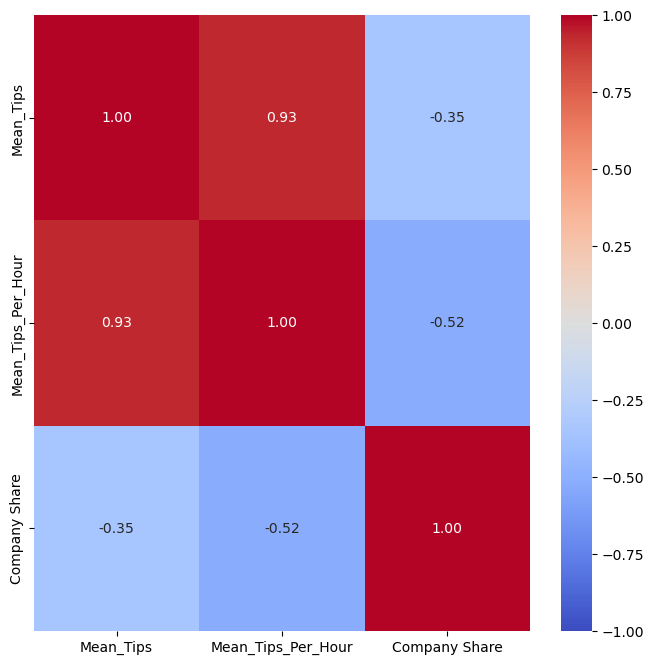

In [31]:
plt.subplots(figsize=(8, 8))

sns.heatmap(data[data['Company Share'] >= 1][['Mean_Tips', 'Mean_Tips_Per_Hour', 'Company Share']].corr(),
            annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
plt.show()


Действительно, имеет место заметная обратная зависимость между средними чаевыми и долей рынка.

Возможно, на пассажиров влияет репутация и имя компании. Или же они чаще склонны считать, что крупные перевозчики больше платят водителям, и оставляют меньше чаевых.


В итоге, для заработка чаевых водителю лучше выбирать компании с меньшей долей перевозок (главное, чтобы не было окон в потоке заказов), выходить на работу утром или вечером в середине недели (последнее не столь несущественно).

Напоследок, исследуем географичекие особенности: существуют ли районы, в которых начинаются поездки с большим значением чаевых и где они находятся, если все же существуют? Построим карту, где точками обозначим начала поездок и цветом размер чаевых за час поездки.

In [32]:
import folium
import branca.colormap as cm

In [33]:
data = df[['Tips Per Hour', 'Pickup Centroid Latitude',
           'Pickup Centroid Longitude']]
data = data.groupby(by=['Pickup Centroid Latitude', 'Pickup Centroid Longitude'], as_index=False).mean()
data = data.rename(columns={'Pickup Centroid Latitude': 'Latitude',
                            'Pickup Centroid Longitude': 'Longitude'})

In [34]:
data

,Latitude,Longitude,Tips Per Hour
0,41.660136,-87.602848,0.118698
1,41.663671,-87.540936,0.185832
2,41.667365,-87.605316,0.000000
3,41.673820,-87.635740,0.212727
4,41.681315,-87.651753,0.000000
...,...,...,...
276,42.015720,-87.687116,0.000000
277,42.015934,-87.666536,0.000000
278,42.016011,-87.680162,0.000000
279,42.016046,-87.673334,0.000000


In [35]:
m = folium.Map(location=[data['Latitude'].mean(),
               data['Longitude'].mean()], zoom_start=11)

colormap = cm.LinearColormap(colors=['blue', 'red'], vmin=data['Tips Per Hour'].min(
), vmax=data['Tips Per Hour'].max())

for index, row in data.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                        radius=5,
                        popup=f'Tips Per Hour: {row["Tips Per Hour"]:.2f}',
                        color=colormap(row['Tips Per Hour']),
                        fill=True,
                        fill_color=colormap(row['Tips Per Hour'])).add_to(m)
    
colormap.add_to(m)
m

По карте видно, что большие показатели чаевых в час у поездок, что стартуют в центре города. На окраинах и в пригороде попадается много точек старта, у которых чаевые за час близятся к нулю, поэтому выгоднее держаться близко к центру города, где показатели бывают в 2-3 раза больше, чем в аэропортах.

На следующем этапе попытаемся построить регрессионную модель машинного обучения, которая будет предсказывать размер чаевых.
В части с исследовательский анализом была представлена общая таблица корреляций. Дополним ее относительно чаевых и временных признаков: дня недели, дня в году, часа в сутках и некоторых их производных.

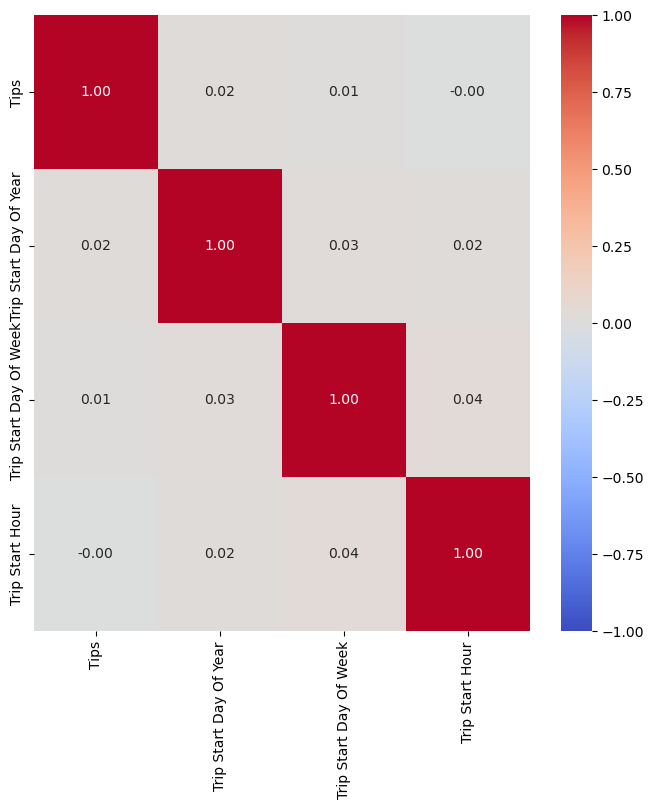

In [36]:
data = df[['Tips', 'Trip Start Day Of Year', 'Trip Start Day Of Week', 'Trip Start Hour']]

plt.subplots(figsize=(8,8))

sns.heatmap(data.corr(),
            annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')

plt.show()

Можно заметить, что Tips совершает примерно 2 осцилляции в сутки, поэтому проверим корреляцию с синусом.

In [37]:
from numpy import sin, pi
data['Trip Start Hour Sin'] = pd.Series(sin(data['Trip Start Hour'].values * 2 * pi / 12 - pi / 2))



/tmp/ipykernel_153875/1973147137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trip Start Hour Sin'] = pd.Series(sin(data['Trip Start Hour'].values * 2 * pi / 12 - pi / 2))


In [38]:
data[['Tips', 'Trip Start Hour Sin']].corr()

,Tips,Trip Start Hour Sin
Tips,1.000000,0.094029
Trip Start Hour Sin,0.094029,1.000000


Корреляция небольшая, но признак может оказаться полезным для модели предсказания.